In [1]:
import numpy as np
import jax.numpy as jnp
import sys
sys.path.append('/users/csmith36/shadows/git_ver')
from shadow_evolution_learning.utils.operations import denseXP, denseXM, denseYP, denseYM, denseZP, denseZM, zero_state, one_state, ket0, ket1, hadamard, phase_z, pX,pY, pZ
from shadow_evolution_learning.utils.time_evolution_simulator import timeEvolution
from shadow_evolution_learning.shadow_sampling.shadow_obs import classicalShadowCalc, estimate_shadow_observable
from shadow_evolution_learning.utils.network_utils import construct_exact_vals
from shadow_evolution_learning.shadow_sampling.shadow_loader import data_loader

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


Define Observables (full matrices)

In [2]:
obs_0 = [-jnp.kron(pZ,jnp.eye(2)),jnp.kron(pY,pX)]
obs_1 = [jnp.kron(jnp.eye(2),pX),jnp.kron(jnp.eye(2),pY)]
obs_2 = [jnp.kron(pX,jnp.eye(2)),jnp.kron(pY,jnp.eye(2))]
p_0 = jnp.kron(obs_0[0],obs_0[1])
p_1 = jnp.kron(obs_1[0],obs_1[1])
p_2 = jnp.kron(obs_2[0],obs_2[1])

q_0 = jnp.kron(obs_0[1],obs_0[1])
q_1 = jnp.kron(obs_1[1],obs_1[1])
q_2 = jnp.kron(obs_2[1],obs_2[1])

full_obs = [[p_0,q_0],[p_1,q_1],[p_2,q_2]]

Define Shadow Observables ( Array(Pauli Matrix index), Array(Qubit) )

so that [0,1,2], [0,1,2] is a $X_0\otimes Y_0\otimes Z_0$

In [3]:

p_0_s = np.array([2,1,0]), np.array([0,2,3])
p_1_s = np.array([0,1]), np.array([1,3])
p_2_s = np.array([0,1]), np.array([0,2])

q_0_s = np.array([1,0,1,0]), np.array([0,1,2,3])
q_1_s = np.array([1,1]), np.array([1,3])
q_2_s = np.array([1,1]), np.array([0,2])

full_shadow_obs = [[p_0_s,q_0_s],[p_1_s,q_1_s],[p_2_s,q_2_s]]

Define shadow_times in steps of 0.005 as that is the interval I sampled times from

In [4]:
dt = 0.005
end_time = 1.5
start_time = 0.1
shadow_times = np.array([round(start_time+dt*(i+1),4) for i in range(int(end_time/dt))])

Define Hamiltonian

In [5]:
index = 0
val_path = '/users/csmith36/shadows/NNSHL/ising/ising_shadow_data/params.npy'
vals = np.load(val_path, allow_pickle=True)
val = vals[index]
pXX = jnp.kron(pX,pX)
hamil = val[0]*pXX + val[1]*jnp.kron(pZ,jnp.eye(2)) + val[2]*jnp.kron(jnp.eye(2),pZ)
        

exact_times can take any continuous value

In [6]:
exact_times = np.linspace(start_time,end_time,num=300)

Construct the exact & shadow observables (meas is # of measurements to in the shadow)

In [7]:
meas = 10000
true_obs = construct_exact_vals(exact_times,hamil,full_obs).reshape(-1,6)
###Set index=0 and base_path to wherever you put the ket00 folder
data_path = '/users/csmith36/shadows/NNSHL/ising/ising_shadow_data/ket_00'
shadow_obs_p_ts, shadow_obs_q_ts = data_loader(shadow_times,meas,index,full_shadow_obs,k=10,base_path=data_path)
full_shadow = np.concatenate([shadow_obs_p_ts,shadow_obs_q_ts],axis=-1)

In [8]:
print(full_shadow.shape)
print(true_obs.shape)

np.save('/users/csmith36/shadows/NNSHL/ising/true_obs.npy',true_obs)
np.save('/users/csmith36/shadows/NNSHL/ising/shadow_obs.npy',full_shadow)
np.save('/users/csmith36/shadows/NNSHL/ising/exact_times.npy',exact_times)
np.save('/users/csmith36/shadows/NNSHL/ising/shadow_times.npy',shadow_times)


(300, 6)
(300, 6)


/users/csmith36/shadows/env/shadows/lib/python3.10/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/users/csmith36/shadows/env/shadows/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


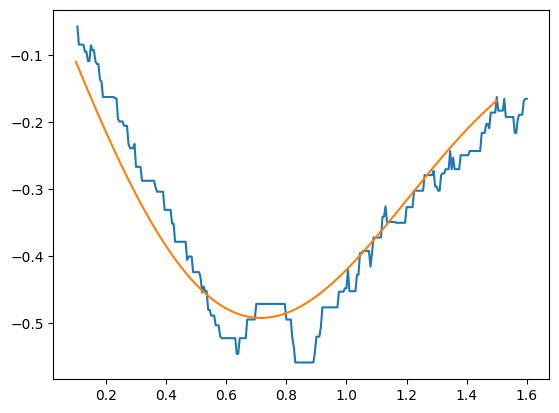

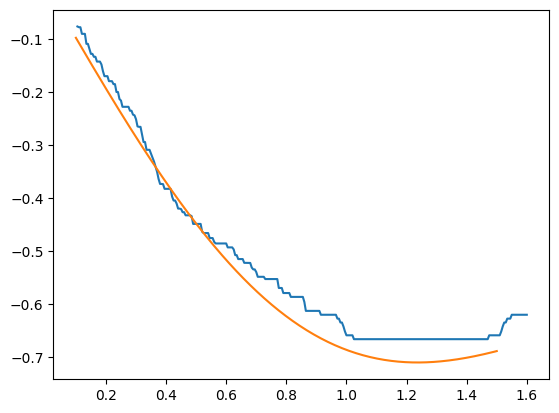

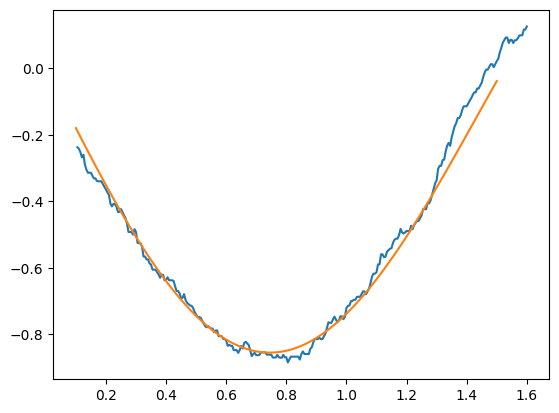

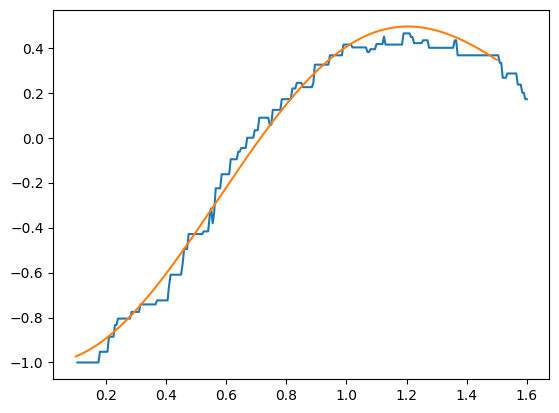

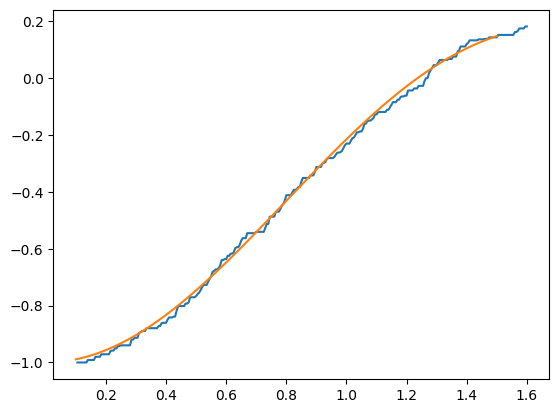

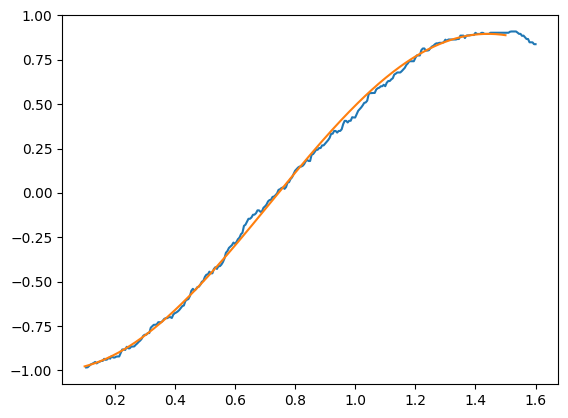

In [30]:
import matplotlib.pyplot as plt
for i in range(6):
    plt.plot(shadow_times,full_shadow[:,i])
    plt.plot(exact_times,true_obs[:,i])
    plt.show()